# Bio-Bert Adverse reaction sentiment analysis

## Importing Libraries
In this cell, we import essential libraries and packages required for the project. 

- *NumPy* and *Pandas* for data manipulation.
- *PyTorch* for model training and data handling.
- *Transformers* library for utilizing pre-trained models and tokenizers.
- *scikit-learn* for model evaluation and data splitting.

In [1]:
import numpy as np
import pandas as pd
import torch
import time
from torch.utils.data import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
                          TrainerCallback, EarlyStoppingCallback, AdamW)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.nn import CrossEntropyLoss

### Custom Callback for Epoch Timing
In this cell, we define a custom callback class named EpochTimeCallback that inherits from TrainerCallback.

#### Purpose:
- To track and display the duration of each training epoch.

#### Implementation Details:
- The on_epoch_begin method records the start time and prints a message indicating the beginning of an epoch.
- The on_epoch_end method calculates the elapsed time and prints the duration when the epoch ends.

In [2]:
# Custom Callback for Epoch Timing
class EpochTimeCallback(TrainerCallback):
    """ Custom callback to print epoch training status with time tracking. """
    def __init__(self):
        self.epoch_start_time = None

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()
        print(f"\n🟢 Epoch {int(state.epoch) + 1}/{args.num_train_epochs} started...")

    def on_epoch_end(self, args, state, control, **kwargs):
        elapsed_time = time.time() - self.epoch_start_time
        print(f"✅ Epoch {int(state.epoch) + 1} completed in {elapsed_time:.2f} seconds.")

### Loading and Labeling Data
In this cell, we perform the following steps:

1. *Data Loading:*
   - Load the training and test datasets from CSV files using pandas.
   - Combine the two datasets using pd.concat().

2. *Data Labeling:*
   - Create a new column Review_Sentiment to label the sentiment:
     - Ratings *>= 5* are labeled as *1* (positive).
     - Ratings *< 5* are labeled as *0* (negative).

#### Status Messages:
- Displays a message when data is loaded and when labeling is complete.

In [3]:
# Load Data
print("🚀 Loading data...")
df = pd.read_csv('../input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv')
test = pd.read_csv('../input/kuc-hackathon-winter-2018/drugsComTest_raw.csv')
data = pd.concat([df, test])
print("✅ Data loaded successfully!")

# Label sentiment based on ratings
print("📝 Labeling sentiment...")
data.loc[data['rating'] >= 5, 'Review_Sentiment'] = 1
data.loc[data['rating'] < 5, 'Review_Sentiment'] = 0


🚀 Loading data...
✅ Data loaded successfully!
📝 Labeling sentiment...


### Data Cleaning, Splitting, and Tokenizer Initialization

1. *Handling Missing Values:*
   - Drop rows where the review field is missing using dropna().
   - Print the number of remaining samples.

2. *Train-Test Split:*
   - Split the data into training and validation sets using train_test_split from sklearn.
   - Use an 80-20 split ratio, maintaining class distribution with stratify.
   - Print the number of samples in each set.

3. *Loading BioBERT Tokenizer:*
   - Load the tokenizer from the pre-trained BioBERT model (dmis-lab/biobert-base-cased-v1.1).
   - Print a message confirming successful loading.

In [4]:
# Handle missing values
data = data.dropna(subset=['review'])
print(f"🔍 Data cleaned! Remaining samples: {len(data)}")

# Train-test split
print("✂ Splitting data into training and validation sets...")
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['review'].tolist(), data['Review_Sentiment'].tolist(), test_size=0.2, random_state=42, stratify=data['Review_Sentiment']
)
print(f"✅ Data split: {len(train_texts)} training samples, {len(val_texts)} validation samples.")

# Load BioBERT tokenizer
print("🔄 Loading BioBERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
print("✅ Tokenizer loaded!")

🔍 Data cleaned! Remaining samples: 215063
✂ Splitting data into training and validation sets...
✅ Data split: 172050 training samples, 43013 validation samples.
🔄 Loading BioBERT tokenizer...


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

✅ Tokenizer loaded!


### Tokenizing Data

1. *Tokenization Process:*
   - Tokenize both training and validation texts using the BioBERT tokenizer.
   - Use the following parameters:
     - truncation=True to ensure that longer texts are truncated.
     - padding=True to pad the sequences for uniform length.
     - max_length=256 to reduce the input length for efficiency.

2. *Status Messages:*
   - Indicate the start and successful completion of tokenization.

In [5]:
# Tokenize data
print("⌛ Tokenizing training and validation data...")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)  # Reduced max_length for efficiency
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)
print("✅ Tokenization complete!")

⌛ Tokenizing training and validation data...
✅ Tokenization complete!


### Custom PyTorch Dataset for Drug Reviews

1. *Dataset Class Definition:*
   - Create a custom dataset class DrugReviewDataset inheriting from torch.utils.data.Dataset.

2. *Class Methods:*
   - __init__: Initializes the dataset with encodings and labels.
   - __len__: Returns the length of the dataset.
   - __getitem__: Retrieves an item by index, converting encodings and labels to PyTorch tensors.
     - Uses torch.long dtype for labels to be compatible with CrossEntropyLoss.

#### Purpose:
- Enables efficient loading and batching of tokenized data for model training.

In [6]:
# Convert to PyTorch Dataset
class DrugReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)  # Fix: Use long dtype for CrossEntropyLoss
        return item

### Custom Callback for Epoch Timing
This cell defines the EpochTimeCallback class to track epoch timing during model training.

#### Class Details:
- Inherits from TrainerCallback.
- Tracks the start and end times of each epoch.
- Prints a message at the beginning and end of every epoch, including the duration in seconds.

In [7]:
# Custom Callback for Epoch Timing
class EpochTimeCallback(TrainerCallback):
    """ Custom callback to print epoch training status with time tracking. """
    def __init__(self):
        self.epoch_start_time = None

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()
        print(f"\n🟢 Epoch {int(state.epoch) + 1}/{args.num_train_epochs} started...")

    def on_epoch_end(self, args, state, control, **kwargs):
        elapsed_time = time.time() - self.epoch_start_time
        print(f"✅ Epoch {int(state.epoch) + 1} completed in {elapsed_time:.2f} seconds.")


### Creating Datasets and Loading Model

1. *Dataset Creation:*
   - Instantiate DrugReviewDataset for both training and validation sets.
   - Print the number of samples in each dataset.

2. *Loading the BioBERT Model:*
   - Load the pre-trained BioBERT model for sequence classification.
   - Set the number of output labels to 2 (binary classification).

3. *Handling Class Imbalance:*
   - Calculate class weights to address imbalanced data.
   - Use the inverse frequency of each class to compute weights.
   - Pass these weights to CrossEntropyLoss for balanced training.

#### Status Messages:
- Indicate the creation of datasets, model loading, and class weight computation.

In [8]:
print("📦 Creating dataset class...")
train_dataset = DrugReviewDataset(train_encodings, train_labels)
val_dataset = DrugReviewDataset(val_encodings, val_labels)
print(f"📊 Training dataset: {len(train_dataset)} samples, Validation dataset: {len(val_dataset)} samples.")

# Load BioBERT model
print("🧠 Loading BioBERT model for sequence classification...")
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=2)
print("✅ Model loaded!")

# Compute class weights for imbalanced dataset
print("⚖ Computing class weights...")
class_counts = np.bincount(train_labels)
weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]], dtype=torch.float32).to(model.device)
loss_fn = CrossEntropyLoss(weight=weights)

📦 Creating dataset class...
📊 Training dataset: 172050 samples, Validation dataset: 43013 samples.
🧠 Loading BioBERT model for sequence classification...


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded!
⚖ Computing class weights...


### Optimizer Setup

- Use the *AdamW* optimizer for model training.
- Key parameters:
  - lr=2e-5: A lower learning rate for better convergence.
  - weight_decay=0.01: Helps with regularization to improve generalization.

#### Why AdamW?
- AdamW is well-suited for transformer-based models as it decouples weight decay from the gradient update, leading to better performance.

In [9]:
# Use AdamW optimizer with custom learning rate

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  # Lower LR and weight decay for better generalization

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Setting Up Training Arguments

1. *Training Configuration:*
   - Output directory: ./biobert_results
   - Evaluation and checkpoint saving at each epoch.
   - Keep only the *3 best checkpoints* to save space.
   - Automatically load the best model at the end.

2. *Batch and Training Parameters:*
   - Batch size: *16* (per device) for both training and evaluation.
   - Number of epochs: *5* (increased for better model learning).
   - Gradient accumulation steps: *2* to effectively increase the batch size.

3. *Performance Enhancements:*
   - Mixed-precision training enabled (fp16=True) for faster computation.
   - Weight decay set to *0.01* for regularization.
   - Learning rate: *2e-5*.
   - Warmup ratio: *0.1* to improve convergence.

4. *Logging and Reporting:*
   - Log every *10 steps*.
   - Logging directory: ./logs.
   - Disable reporting to external tools (like W&B).

#### Status Messages:
- Indicate successful setup of training arguments.

In [13]:
# Define training arguments
print("⚙ Setting up training arguments...")
training_args = TrainingArguments(
    output_dir="./biobert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,  # Keep only 3 best checkpoints
    load_best_model_at_end=True,
    per_device_train_batch_size=16,  # Increased batch size
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Increased epochs from 3 to 5
    gradient_accumulation_steps=2,  # Helps stabilize training
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",  # Disable W&B logs
    fp16=True,  # Enables mixed-precision training
    weight_decay=0.01,
    learning_rate=2e-5,
    warmup_ratio=0.1,  # Helps with convergence
)
print("✅ Training arguments set!")

⚙ Setting up training arguments...
✅ Training arguments set!


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Initializing the Trainer

1. *Trainer Configuration:*
   - Uses the *BioBERT model* and the previously defined training_args.
   - Sets the training and validation datasets.

2. *Custom Callback:*
   - Integrates the EpochTimeCallback to track the time taken for each epoch.

#### Status Message:
- Confirms the initialization of the Trainer with live tracking.

In [14]:
print("📢 Initializing Trainer with live tracking...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EpochTimeCallback()]  # Adding our custom callback
)

📢 Initializing Trainer with live tracking...


### 🧠 Model Training and Evaluation

This code block performs the training and evaluation of a machine learning model using a trainer object.

1. **Training the Model**  
   - `trainer.train()`: Begins the model training process.
   - Displays messages before and after training to track progress.

2. **Evaluating the Model**  
   - `trainer.predict(val_dataset)`: Runs the trained model on the validation dataset to get predictions.
   - `np.argmax(...)`: Extracts the predicted class labels from the raw model output.
   - `accuracy_score(...)`: Computes the accuracy by comparing predicted labels with actual validation labels.
   - `classification_report(...)`: Prints detailed precision, recall, F1-score for each class.

3. **Output**  
   - Displays validation accuracy and a full classification report for performance insight.

📌 Useful for checking how well the model generalizes to unseen data.


In [15]:
# Train Model
print("🚀 Training started...")
trainer.train()
print("🎉 Training complete!")

# Evaluate Model
print("📊 Evaluating model performance on validation set...")
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
accuracy = accuracy_score(val_labels, preds)

print(f"✅ Validation Accuracy: {accuracy:.4f}")
print("📋 Classification Report:")
print(classification_report(val_labels, preds))

🚀 Training started...

🟢 Epoch 1/5 started...


Epoch,Training Loss,Validation Loss
1,0.135300,0.327636
2,0.138100,0.173327
3,0.101300,0.191667
4,0.024600,0.220359
5,0.021400,0.232645


✅ Epoch 2 completed in 3962.20 seconds.

🟢 Epoch 2/5 started...
✅ Epoch 3 completed in 3960.44 seconds.

🟢 Epoch 3/5 started...
✅ Epoch 4 completed in 3956.46 seconds.

🟢 Epoch 4/5 started...
✅ Epoch 5 completed in 3953.21 seconds.

🟢 Epoch 5/5 started...
✅ Epoch 6 completed in 3957.73 seconds.
🎉 Training complete!
📊 Evaluating model performance on validation set...


✅ Validation Accuracy: 0.9445
📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     10714
         1.0       0.96      0.96      0.96     32299

    accuracy                           0.94     43013
   macro avg       0.93      0.93      0.93     43013
weighted avg       0.94      0.94      0.94     43013



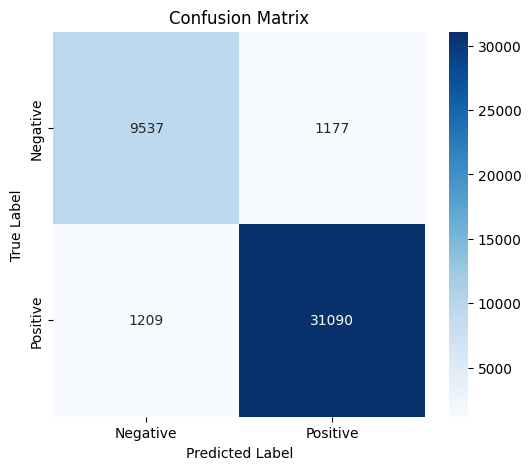

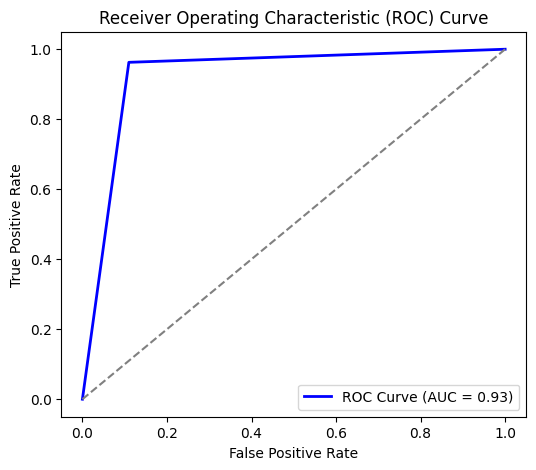

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Generate confusion matrix
conf_matrix = confusion_matrix(val_labels, preds)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(val_labels, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


## 📊 Model Evaluation Report - BIO- BERT

### 🏆 Performance Metrics
The BERT model was evaluated using a validation dataset of **43,013 samples**, and the key performance metrics are:

- **Validation Accuracy**: **94.45%**
- **Classification Report**:
  - **Precision**: 
    - Class 0 (Negative): **0.89**
    - Class 1 (Positive): **0.96**
  - **Recall**:
    - Class 0 (Negative): **0.89**
    - Class 1 (Positive): **0.96**
  - **F1-score**: 
    - Class 0 (Negative): **0.89**
    - Class 1 (Positive): **0.96**
  - **Weighted Avg Accuracy**: **0.94**

---

### 📌 Confusion Matrix Analysis
The confusion matrix indicates:

| **True Label →** | **Predicted Negative** | **Predicted Positive** |
|-----------------|----------------------|----------------------|
| **Negative (0)** | **9,537** (True Negative) | **1,177** (False Positive) |
| **Positive (1)** | **1,209** (False Negative) | **31,090** (True Positive) |

- **False Positive Rate** (Type I Error): **1,177 cases**  
- **False Negative Rate** (Type II Error): **1,209 cases**  
- Majority of the misclassifications occur with **false negatives** (positive cases wrongly classified as negative).

---

### 📈 Receiver Operating Characteristic (ROC) Curve
- The **ROC Curve** demonstrates a high AUC (**0.93**), signifying strong model performance.
- The model effectively distinguishes between positive and negative classes.

---

## 📌 Conclusion

- The **BERT model performs exceptionally well** with a high validation accuracy (**94.45%**).
- The **precision and recall are balanced**, indicating that the model is **not biased** toward any specific class.
- **Misclassification is minimal**, but **false negatives (1,209 cases)** should be further analyzed to reduce errors in critical applications.
- **Next Steps**:
  - **Hyperparameter tuning** to further optimize the model.
  - **Data augmentation** to enhance robustness.
  - **Threshold adjustment** to minimize false negatives.

🚀 **Overall, this BERT model is highly effective for text classification tasks!**


In [17]:
# Save the trained BioBERT model
model.save_pretrained("./saved_biobert_model")
tokenizer.save_pretrained("./saved_biobert_model")

print("✅ Model and tokenizer saved successfully!")


✅ Model and tokenizer saved successfully!


In [18]:
from transformers import AutoModel
import torch

# Load base BioBERT model (without classification head)
biobert = AutoModel.from_pretrained("./saved_biobert_model")
biobert.eval()

# Sample input (can be a batch as well)
text = "The drug helped with my condition but caused severe headaches."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Extract embeddings (last hidden state)
with torch.no_grad():
    outputs = biobert(**inputs)
    last_hidden_state = outputs.last_hidden_state 
    cls_embedding = last_hidden_state[:, 0, :]    

print("📐 Extracted [CLS] embedding shape:", cls_embedding.shape)


📐 Extracted [CLS] embedding shape: torch.Size([1, 768])


In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the saved fine-tuned BioBERT model and tokenizer
model_path = "./saved_biobert_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.eval()

# Function to predict sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][predicted_class].item()

    sentiment = "Positive" if predicted_class == 1 else "Negative"
    print(f"📝 Review: {text}")
    print(f"🔍 Predicted Sentiment: {sentiment} (Confidence: {confidence:.2f})")
    return predicted_class, confidence

# 🔄 Example usage
sample_review = "This medicine worked wonderfully for my condition!"
predict_sentiment(sample_review)


📝 Review: This medicine worked wonderfully for my condition!
🔍 Predicted Sentiment: Positive (Confidence: 1.00)


(1, 0.9992451667785645)

In [21]:
predict_sentiment("I felt worse after taking this drug. Not recommended.")
predict_sentiment("I took paracetamol to relieve a headache, as I’ve done before, but this time something felt off. About an hour after taking the tablet, I started feeling unusually dizzy and nauseous. My stomach began to hurt, and I felt a burning sensation in my upper abdomen. I thought it would pass, but then I started sweating and feeling extremely tired, almost like I was about to faint.Later that evening, I noticed my skin looked a bit yellowish, and my urine had turned darker than usual. That’s when I got really worried and went to the hospital. The doctors ran some tests and told me my liver enzymes were elevated — apparently, I had signs of liver stress or damage, possibly due to the paracetamol.I never imagined something so common could cause such a serious reaction. Now I’m more careful with medications and always check the dosage and possible side effects.")


📝 Review: I felt worse after taking this drug. Not recommended.
🔍 Predicted Sentiment: Negative (Confidence: 1.00)
📝 Review: I took paracetamol to relieve a headache, as I’ve done before, but this time something felt off. About an hour after taking the tablet, I started feeling unusually dizzy and nauseous. My stomach began to hurt, and I felt a burning sensation in my upper abdomen. I thought it would pass, but then I started sweating and feeling extremely tired, almost like I was about to faint.Later that evening, I noticed my skin looked a bit yellowish, and my urine had turned darker than usual. That’s when I got really worried and went to the hospital. The doctors ran some tests and told me my liver enzymes were elevated — apparently, I had signs of liver stress or damage, possibly due to the paracetamol.I never imagined something so common could cause such a serious reaction. Now I’m more careful with medications and always check the dosage and possible side effects.
🔍 Predicted 

(0, 0.9698763489723206)

In [22]:
import shutil

zip_name = "biobert_model_package.zip"
shutil.make_archive("biobert_model_package", 'zip', "saved_biobert_model")
print(f"Zipped as {zip_name}")


Zipped as biobert_model_package.zip
